In [35]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import gymnasium as gym
import enflow as ef
import treewe as tr

### Load problem

In [39]:
tr.list_problems()

['gefcom2014-wind', 'gefcom2014-solar']

In [40]:
dataset, env, obj = tr.load_problem("gefcom2014-solar")

In [41]:
portfolio = dataset.collection
portfolio.draw_tree(show_type=True)

Portfolio (edm.Portfolio)
├── Site1 (edm.PVSystem)
├── Site2 (edm.PVSystem)
└── Site3 (edm.PVSystem)


### Create prediction model


In [42]:
import lightgbm as lgb
import pandas as pd
from contextlib import nullcontext

class LGBGEFCom2014Predictor(ef.Predictor):
    def __init__(self, portfolio: ef.Portfolio, name=None, quantiles=None):
        """
        Initialize the Predictor class.
        
        Args:
            quantiles (list): List of quantiles for which to create separate models.
                              Example: [0.1, 0.5, 0.9]
        """

        self.portfolio = portfolio
        self.name = name
        self.models = {}  # Dictionary to hold models for each site and quantile
        self.quantiles = quantiles
    
    def preprocess(self, df_features: pd.DataFrame) -> pd.DataFrame:
        
        # Reassign df to a copy only within the function scope
        df_features = df_features.copy()

        # Add lead time feature
        ref_datetime = df_features.index.get_level_values(0)
        valid_datetime = df_features.index.get_level_values(1)
        lead_time = (valid_datetime-ref_datetime)/pd.Timedelta('1 hour')
        for asset in portfolio.assets:
            df_features.loc[:,(asset.name,'lead_time')] = lead_time

        # Differentiate accumulated features
        features_accum = ['VAR169', 'VAR175', 'VAR178', 'VAR228']
        df_accum = df_features.loc[:,(slice(None),features_accum)]
        df_accum = df_accum.diff()
        df_accum[df_accum.index.get_level_values(1).hour==1] = df_features.loc[df_accum.index.get_level_values(1).hour==1,(slice(None),features_accum)]
        df_accum.loc[:,(slice(None),features_accum[:3])] = df_accum.loc[:,(slice(None),features_accum[:3])]/3600 # Convert from J to Wh/h
        df_features.loc[:,(slice(None),features_accum)] = df_accum 

        # Calculate solar position
        index = df_features.index.get_level_values(1)
        for asset in portfolio.assets: 
            df_solpos = asset.location.to_pvlib().get_solarposition(index)
            df_solpos = df_solpos.loc[:, ['zenith', 'azimuth']]
            df_solpos.index = df_features.index
            for column in df_solpos.columns: 
                df_features[(asset.name, column)] = df_solpos[column]

        # Calculate clearsky power
        for asset in portfolio.assets: 
            clearsky_power = tr.clearsky_power(asset, index)
            df_features[(asset.name, "clearsky_power")] = clearsky_power
        
        # Calculate physical power
        for asset in portfolio.assets: 
            physical_power = tr.physical_power(asset, df_features[(asset.name, "VAR169")].droplevel(0))
            df_features[(asset.name, "physical_power")] = physical_power.values 

        return df_features

    def train(self, df_features: pd.DataFrame, target: pd.DataFrame, show_progress=True, **kwargs):
        """
        Train separate LightGBM models for each site and quantile.
        
        Args:
            features (pd.DataFrame): Multi-indexed dataframe where the top-level index corresponds to sites.
            target (pd.DataFrame): The target dataframe (y), also multi-indexed by site.
            kwargs: Additional parameters to pass to the LightGBMRegressor model.
        """

        df_features = self.preprocess(df_features)

        # Get the list of unique sites from the multi-index (top level)
        sites = df_features.columns.get_level_values(0).unique()
        feature_names = df_features.columns.get_level_values(1).unique()

        pbar = tqdm(total=len(sites)*len(self.quantiles), mininterval=0, desc=f"Training {self.name}") if show_progress else nullcontext()

        with pbar as progress: 
            # Loop over each site
            for site in sites:
                # Extract the features and target for the current site
                site_features = df_features.xs(site, axis=1, level=0)
                site_target = target.xs(site, axis=1, level=0)
                site_target = site_target["Power"]-site_features["physical_power"]

                # Loop over each quantile
                for quantile in self.quantiles:
                    # Initialize a LightGBM model for this quantile
                    params = {'objective': 'quantile', 'alpha': quantile, "verbose": -1}
                    params.update(kwargs)  # Add any additional LightGBM parameters
                    
                    model = lgb.LGBMRegressor(**params)
                    
                    # Train the model on the site's data
                    model.fit(site_features, site_target)
                    
                    # Store the trained model with a key (site, quantile)
                    self.models[(site, quantile)] = model

                    if show_progress: 
                        progress.update(1)

    def predict(self, df_features: pd.DataFrame) -> pd.DataFrame:
        """
        Make predictions for a specific site and quantile using the trained model.
        
        Args:
            df_features (pd.DataFrame): The feature dataframe (X), multi-indexed column by site.
        
        Returns:
            pd.DataFrame: Predictions from the model.
        """

        df_features = self.preprocess(df_features)

        # Create a nested dictionary to store predictions
        predictions = {}

        # Extract the features for the specific site
        sites = df_features.columns.get_level_values(0).unique()

        # Loop over each site and quantile
        for site in sites:
            # Extract the features for the current site
            site_features = df_features.xs(site, axis=1, level=0)

            # Initialize an inner dictionary for each site

            for quantile in self.quantiles:
                # Check if the model for the given site and quantile exists
                if (site, quantile) not in self.models:
                    raise ValueError(f"No trained model for site '{site}' and quantile '{quantile}'.")

                # Make predictions using the stored model
                model = self.models[(site, quantile)]
                site_predictions = model.predict(site_features)                      
                site_predictions = site_predictions+site_features["physical_power"].values

                # Store the predictions under the quantile for the current site
                predictions[(site, f"quantile_{round(100*quantile)}")] = site_predictions

        # Convert the nested dictionary to a DataFrame with multi-index columns
        df_predictions = pd.DataFrame.from_dict(predictions)
        df_predictions.index = df_features.index
        
        return df_predictions


### Step 6) Run the sequential decision loop and evaluate performance

In [43]:
initial_data, next_input = env.reset()

In [ ]:
training_input = initial_data["input"]
training_target = initial_data["target"]
predictor1 = LGBGEFCom2014Predictor(portfolio=portfolio, name="predictor1", quantiles=[0.1, 0.5, 0.9])
predictor1.train(df_features=training_input, target=training_target)

predictor2 = predictor1.copy(name="predictor2")

Training predictor1: 100%|██████████| 9/9 [00:02<00:00,  4.13it/s]


In [33]:
losses = {predictor1.name: [], predictor2.name: []}
predictions = []
for i in range(env.n_steps):
    prediction1 = predictor1.predict(df_features=next_input)
    prediction2 = predictor2.predict(df_features=next_input)
    predictions.append(prediction1)

    training_input = pd.concat([training_input, next_input])
    next_input, next_target, done = env.step()
    training_target = pd.concat([training_target, next_target])

    loss1 = obj.calculate(next_target, prediction1)
    loss2 = obj.calculate(next_target, prediction2)

    losses[predictor1.name].append(loss1)
    losses[predictor2.name].append(loss2)

    predictor2.train(df_features=training_input, target=training_target)

    print(f"{predictor1.name} {obj.name} for step {i+1}: {loss1}")
    print(f"{predictor2.name} {obj.name} for step {i+1}: {loss2}")

Training predictor2: 100%|██████████| 9/9 [00:01<00:00,  4.61it/s]


predictor1 PinballLoss for step 1: 0.011204054803155625
predictor2 PinballLoss for step 1: 0.011204054803155625


Training predictor2: 100%|██████████| 9/9 [00:01<00:00,  5.29it/s]


predictor1 PinballLoss for step 2: 0.009240390300022897
predictor2 PinballLoss for step 2: 0.009063758759589114


Training predictor2: 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]


predictor1 PinballLoss for step 3: 0.010753606907901054
predictor2 PinballLoss for step 3: 0.010443964712996245


Training predictor2: 100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


predictor1 PinballLoss for step 4: 0.012257128079863674
predictor2 PinballLoss for step 4: 0.012103222813525286


Training predictor2: 100%|██████████| 9/9 [00:01<00:00,  5.41it/s]


predictor1 PinballLoss for step 5: 0.015709185957303754
predictor2 PinballLoss for step 5: 0.015349049969093274


Training predictor2: 100%|██████████| 9/9 [00:01<00:00,  4.76it/s]


predictor1 PinballLoss for step 6: 0.010714876092921388
predictor2 PinballLoss for step 6: 0.010428383539273101


Training predictor2: 100%|██████████| 9/9 [00:01<00:00,  5.13it/s]


predictor1 PinballLoss for step 7: 0.01060918593113412
predictor2 PinballLoss for step 7: 0.010258284122606633


Training predictor2: 100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


predictor1 PinballLoss for step 8: 0.011098529790581903
predictor2 PinballLoss for step 8: 0.010757249681650975


Training predictor2: 100%|██████████| 9/9 [00:01<00:00,  5.36it/s]


predictor1 PinballLoss for step 9: 0.011700506431809785
predictor2 PinballLoss for step 9: 0.011300162463063212


Training predictor2: 100%|██████████| 9/9 [00:01<00:00,  4.50it/s]


predictor1 PinballLoss for step 10: 0.011686086915546115
predictor2 PinballLoss for step 10: 0.011458028889962996


Training predictor2: 100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


predictor1 PinballLoss for step 11: 0.01105819817215981
predictor2 PinballLoss for step 11: 0.010466426422608343


Training predictor2: 100%|██████████| 9/9 [00:02<00:00,  4.42it/s]


predictor1 PinballLoss for step 12: 0.01254798074217749
predictor2 PinballLoss for step 12: 0.012111680115991199


Training predictor2: 100%|██████████| 9/9 [00:01<00:00,  4.77it/s]


predictor1 PinballLoss for step 13: 0.010533883821107594
predictor2 PinballLoss for step 13: 0.01007272056513573


Training predictor2: 100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


predictor1 PinballLoss for step 14: 0.008110719272860376
predictor2 PinballLoss for step 14: 0.0074295384959401


Training predictor2: 100%|██████████| 9/9 [00:02<00:00,  4.45it/s]

predictor1 PinballLoss for step 15: 0.012833636041290689
predictor2 PinballLoss for step 15: 0.01174686713140884


In [44]:
df_predictions = pd.concat(predictions)
env.plot_forecasts(training_target, df_predictions, site="Site1")

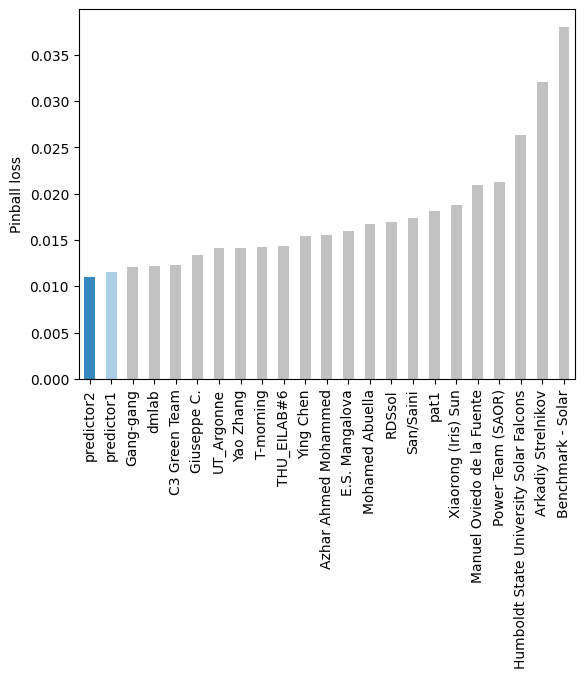

In [34]:
env.plot_overall_results(losses, 
                         drop_tasks=["Task1", "Task2", "Task3", "Task4"]);

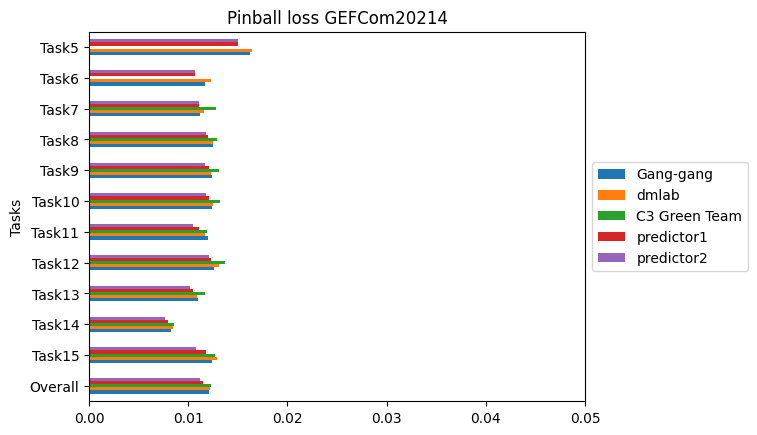

In [32]:
env.plot_results(losses, 
                 drop_tasks=["Task1", "Task2", "Task3", "Task4"], 
                 n_top_teams=3,
                 xlim=0.05);